In [16]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from functions.generate import get_generator, generate_time_series

In [17]:
t = 300 # days
changepoints = 10 # number of chamngepoints 
fourier_series_n = 10 # number of fourier series folds
k = 1 # growth rate
m = 0 # offset parameter
P = 7 # parameter for fourier series 7 - weekly, 365 - yearly ...
D = 5 # specific holidays

In [18]:
key = jax.random.PRNGKey(2137)
_, A = get_generator(max_length=t, max_fourier_order=fourier_series_n)
Y, w = generate_time_series(key, A, batch_size=3)

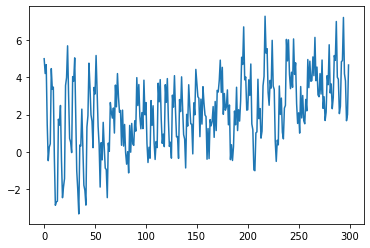

In [19]:
plt.plot(list(range(t)), list(Y[2]))
plt.show()

### Trend

In [20]:
def get_changepoint_matrix(T, S):
    step = T/(S+1)
    s = jnp.arange(start=0, stop=T, step=step).astype(int)[1:]
    f = jax.vmap(lambda x: jnp.where(jnp.arange(T) >= x, jnp.ones(T), jnp.zeros(T)), 0, 0)
    A = f(s).T
    return A, s

In [21]:
def get_trend(params, T, A, s):
    k, m, ro = params["k"], params["m"], params["ro"]
    trend = (k+A@ro)*T + (m - A@(s*ro))
    return trend

### Seasonality

In [22]:
def get_seasonality(params, T, P, N):
    n = jnp.arange(N)
    t = jax.numpy.expand_dims(T, 1)
    fraction = 2 * np.pi / P * n
    fraction = t * fraction 
    sins = jax.numpy.sin(fraction) 
    coss = jax.numpy.cos(fraction) 
    fourier = jax.numpy.concatenate((sins,coss), axis=1)
    beta = params["beta"]
    seasonality = jax.numpy.sum(fourier * beta, axis=1)
    return seasonality

### Holidays

In [23]:
def get_holidays(params, T, D, seed=420):
    holidays_matrix = jnp.zeros((T.shape[0],D))
    np.random.seed(seed)
    for i in range(D-1):
        indexes = np.random.choice(np.arange(t), np.random.randint(t*0.05,t*0.2))
        holidays_matrix = holidays_matrix.at[indexes, i].set(1)
    indexes = np.arange(0,t,7,dtype=int)
    holidays_matrix = holidays_matrix.at[indexes, D-1].set(1)
    kappa = params["kappa"]
    holidays = jax.numpy.sum(holidays_matrix * kappa, axis=1)
    return holidays

### Results

In [32]:
import jax.numpy as jnp
import jax
def loss_linear(params, X, Y, changepoints, A,s):
    return jnp.mean((model_linear(params,X,changepoints,A,s)-Y)**2)
def model_linear(params, X, changepoints, A,s):
    trend = get_trend(params, X, A, s)
    seasonality = get_seasonality(params, X, P, fourier_series_n)
    holidays = get_holidays(params, X, D)
    #print(trend.shape)
    #print(seasonality.shape)
    #rint((trend+seasonality+holidays).shape)
    return trend+seasonality+holidays
#@jax.jit
def update_linear(X, Y, params, lr, changepoints, A, s):
    loss, grads = jax.value_and_grad(loss_linear)(params,X,Y,changepoints,A,s)
    print(loss)
    new_params = jax.tree_multimap(lambda p, g: p - lr*g, params, grads)
    return new_params, loss
def fit_linear_prophet(X, Y, lr, epochs, changepoints, A,s):
    params = {}
    params["k"] = jnp.ones((1,)) * 0.1
    params["m"] = jnp.ones((1,)) * 0.1
    params["ro"] = jnp.ones((A.shape[1],)) * 0.1
    params["beta"] = jnp.ones((2*fourier_series_n,)) * 0.1
    params["kappa"] = jnp.ones((D,)) * 0.1
    for i in range(epochs):
        params, loss = update_linear(X,Y,params,lr,changepoints,A,s)
    print(loss)
    return params
def infer_linear_prophet(X, params, changepoints, A,s):
    return model_linear(params,X,changepoints,A,s)

In [33]:
s.shape

(10,)

In [34]:
A, s = get_changepoint_matrix(t, changepoints)
prophet = fit_linear_prophet(jnp.arange(t), Y[2], 0.0005, 1000, changepoints, A, s)

(300,)
6459.3813
(300,)
56737028.0
(300,)
503020030000.0
(300,)
4459693000000000.0
(300,)
3.9538887e+19
(300,)
3.505453e+23
(300,)
3.107878e+27
(300,)
2.7553917e+31
(300,)
2.4428865e+35
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
inf
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
(300,)
nan
